In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
import pesos
import abscissa
import metodos_integracao_numerica as int_num
from metodos_minimos_quadrados import minimos_quadrados_cont as mmq_cont
from metodos_sistemas_lineares import LU, Thomas

## Classe para resolução de Elementos Finitos

In [2]:
class ElementosFinitos:
    def __init__(self,a,b,nel,npontos,epsilon):
        self.a = a
        self.b = a
        self.nel = nel
        self.npontos = npontos
        self.epsilon = epsilon
        self.h = (b-a)/nel
        self.hm = 2/(npontos-1)
        # Pontos espaçados pelo numero de elementos
        self.x = [x for x in np.arange(a,b+self.h,self.h)]
        # Pontos espaçados pelo numero de pontos
        self.xp = [x for x in np.arange(-1,1+self.hm,self.hm)]
        
        self.w = pesos.pesos() # Pesos da quadratura de gauss
        self.t = abscissa.abscissas() # Abscissas da quadratura de gauss
        
        # K e F global de tamanho ordem do polinomio * num elementos + 1
        self.Kglobal = np.zeros((nel*(npontos-1)+1,nel*(npontos-1)+1))
        self.Fglobal = np.zeros((nel*(npontos-1)+1))
    
    def phi(self, x, i):
        c = 1
        d = 1
        ind = []
        for j in range(self.npontos):
            if i != j:
                ind.append(j)
                c = c*(x-self.xp[j])
                d = d*(self.xp[i] - self.xp[j])

        dp = 0
        for j in range(self.npontos-1):
            k = ind[j]
            if self.npontos <= 2:
                dp += 1.0/d
            else:
                dp += (x-self.xp[k])/d
            
        return (c/d, dp)
    
    def quadratura_gauss(self,ki,kj):
        # leio o pesos e as abssisas a partir de n
        wn = self.w[self.npontos]
        tn = self.t[self.npontos]
        integral_K = np.float128(0.0)
        integral_F = np.float128(0.0)

        # mudança de variável
        x_linha = 2.0/self.h
        
        # Calculando integrais de K local
        for i in range(self.npontos):
            # produto dos valores da derivada de phi de i e j
            phiI, dphiI = self.phi(tn[i],ki)
            phiJ, dphiJ = self.phi(tn[i],kj)
            
            prod = dphiI * x_linha * dphiJ * x_linha * self.epsilon + (phiI*phiJ)
            
            integral_K += np.float128(wn[i] * prod * (self.h/2.0))
            
        # Calculando integrais de F local
        for i in range(self.npontos):
            # produto dos valores da derivada de phi de j e a função f
            integral_F += np.float128(wn[i] * self.phi(tn[i],kj)[0] * (self.h/2.0))
    
        return integral_K, integral_F
    
    def calcula_local(self):
        K = np.zeros((self.npontos,self.npontos))
        F = np.zeros((self.npontos))
        
        for i in range(len(K)):
            for j in range(len(K)):
                integrais = self.quadratura_gauss(i,j)
                K[i][j] = integrais[0]
                
        for j in range(len(F)):
            integrais = self.quadratura_gauss(0,j)
            F[j] = integrais[1]
        
        return K, F
    
    def calcula_global(self):
        # Calculando K e F locais
        K = self.calcula_local()[0]
        F = self.calcula_local()[1]

        # Preenchendo K global
        for n in range(self.nel):
            i = n*(self.npontos-1)
            for l in range(len(K[0])):
                for c in range(len(K[0])):
                    self.Kglobal[i+l][i+c] += K[l][c]
                    
        # Preenchendo F global
        for n in range(self.nel):
            i = n*(self.npontos-1)
            for j in range(len(F)):
                self.Fglobal[i+j] += F[j]

        # Zerando os cantos da matriz
        self.Kglobal[0][0] = self.Kglobal[-1][-1] = 1
        for i in range(1,self.npontos):
            self.Kglobal[i][0] = self.Kglobal[0][i] = 0
            self.Kglobal[-1][-1-i] = self.Kglobal[-1-i][-1] = 0
            
        self.Fglobal[0] = self.Fglobal[-1] = 0
        
        return self.Kglobal, self.Fglobal
    
    def solucao(self):
        self.calcula_global()
        return LU(self.Kglobal,self.Fglobal)[0]

In [3]:
def c2(epsilon):
    return (math.exp(-1/math.sqrt(epsilon)) - 1)/(math.exp(1/math.sqrt(epsilon)) - math.exp(-1/math.sqrt(epsilon)))

def c1(epsilon,c2):
    return -1-c2(epsilon)

def u(x,epsilon,c1,c2):
    return c1(epsilon,c2) * math.exp(-x/math.sqrt(epsilon)) + c2(epsilon)* math.exp(x/math.sqrt(epsilon)) + 1

In [4]:
x = np.arange(0,1.01,0.01)
y = [u(xi,10**-3,c1,c2) for xi in x]

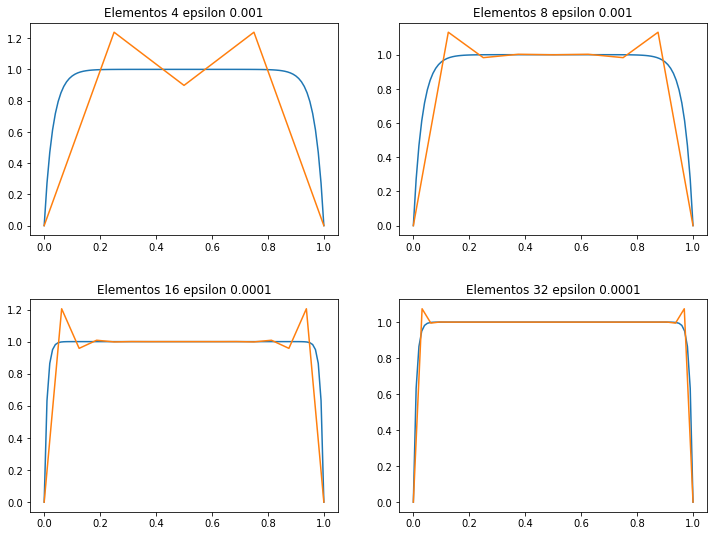

In [5]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.2)

nel = [4,8,16,32]
eps = [10**-3,10**-3,10**-4,10**-4]

l = 0
c = 0

for i in range(len(nel)):
    #  Exata
    x = np.arange(0,1.01,0.01)
    y = [u(xi,eps[i],c1,c2) for xi in x]
    
    # Aproximada
    p = ElementosFinitos(0,1,nel[i],2,eps[i])
    yu = p.solucao()
    h = 1/(len(yu)-1)
    xu = np.arange(0,1+h,h)
    axarr[l,c].plot(x,y)
    axarr[l,c].plot(xu,yu)
    axarr[l,c].set_title('Elementos '+str(nel[i])+' epsilon '+str(eps[i]))
    if c < len(nel)/2 - 1:
        c+=1
    else:
        l+=1
        c = 0
    

# plt.show()
plt.savefig('ordem1.png')

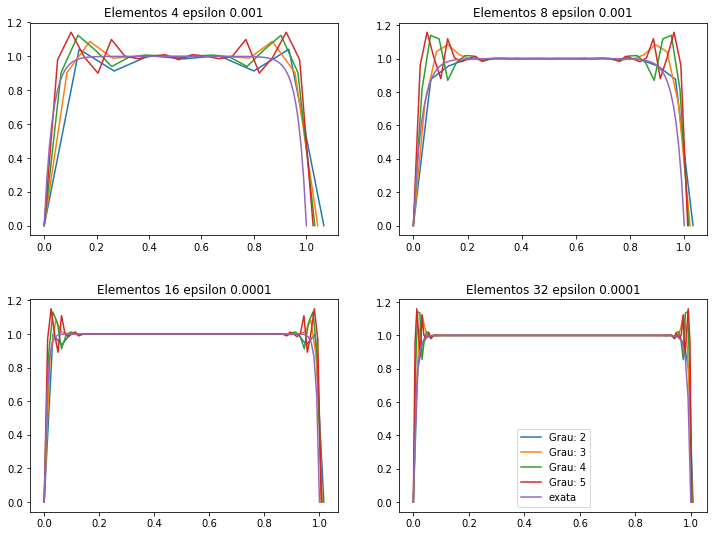

In [7]:
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
fig.subplots_adjust(left=0.03, right=0.97, hspace=0.3, wspace=0.2)

nel = [4,8,16,32]
eps = [10**-3,10**-3,10**-4,10**-4]
npontos = [3,4,5,6]

l = 0
c = 0

for i in range(len(nel)):
    for n in npontos:
        #  Exata
        x = np.arange(0,1.01,0.01)
        y = [u(xi,eps[i],c1,c2) for xi in x]

        # Aproximada
        p = ElementosFinitos(0,1,nel[i],n,eps[i])
        yu = p.solucao()
        h = 1/(len(yu)-1.5)
        xu = np.arange(0,1+h,h)
        axarr[l,c].plot(xu,yu,label='Grau: '+str(n-1))
    
    axarr[l,c].plot(x,y,label='exata')
    axarr[l,c].set_title('Elementos '+str(nel[i])+' epsilon '+str(eps[i]))
    if c < len(nel)/2 - 1:
        c+=1
    else:
        l+=1
        c = 0
    
plt.legend()
# plt.show()
plt.savefig('elfin_todos.png')

In [16]:
def norma_max(analitica, estimado):
    max = abs(analitica[0] - estimado[0])
    for (real, est) in zip(analitica, estimado):
        erro = abs(real - est)
        if erro > max: max = erro
    return max

In [ ]:
erro = np.zeros((5,5))

for i in range(1,6):
    for j in range(1,6):
        # Aproximada
        p = ElementosFinitos(0,1,4**j,i+1,10**-3)
        yu = p.solucao()
        h = 1/(len(yu)-1.5)
        xu = np.arange(0,1+h,h)
        
        #  Exata
        x = np.arange(0,1+h,h)
        y = [u(xi,10**-3,c1,c2) for xi in x]
        
        erro[i-1][j-1] = np.log(norma_max(y,yu))


### Diferenças finitas

In [42]:
def TDMASolve(a, b, c, d):
    ''' Resolve Ax = d onde A é uma matriz tridiagonal composta pelos vetores a, b, c
    a - subdiagonal
    b - diagonal principal
    c - superdiagonal
    Retorna x
    '''
#     print('diagonais: ', a, b, d, c)
    n = len(d) # len(d) == len(b)
    c_ = [ c[0] / b[0] ]
    d_ = [ d[0] / b[0] ]
    
    for i in range(1, n):
        aux = b[i] - c_[i-1]*a[i-1]
        if i < n-1:
            c_.append( c[i] / aux )
        d_.append( (d[i] - d_[i-1]*a[i-1])/aux )
    
    # Substituição de volta
    x = [d_[-1]]
    for i in range(n-2, -1, -1):
        x = [ d_[i] - c_[i]*x[0] ] + x
    
    return x

In [21]:
def discretizacao_PVC(h,epsilon):
    return ((h ** 2)/ epsilon)

## Análise de Erros

In [73]:
n = [4,4**2,4**3,4**4,4**5]
epsilon = 10**-3
erro_df = []

for j in range(len(n)):
    h = 1/n[j]
    fx = []
    ya = []
    
    a = c =[-1]*len(np.arange(0,1,h))
    b = [2+(h**2)/epsilon]*len(np.arange(0,1+h,h))
    
    for x in np.arange(0,1+h,h):
        ya.append(np.float32(u(x,epsilon,c1,c2)))
    
    # Adquirindo valores do termo dependente
    for i in np.arange(h,1,h):
        fx.append(np.float32(discretizacao_PVC(h, epsilon)))
            
    # Adquirindo valores a partir do algoritmo de thomas
    y_disc = TDMASolve(a,b,c,fx)
    # Inserindo valor inicial e final
    y_disc.insert(0,0)
    y_disc.append(0)
    
    erro_df.append(np.log(norma_max(ya,y_disc)))

In [69]:
tam = [4,4**2,4**3,4**4,4**5]

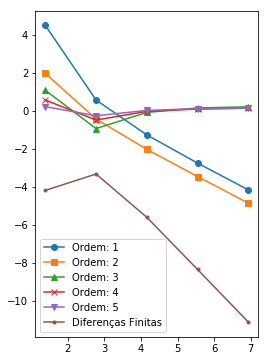

In [76]:
mark = ['o','s','^','x','v','.']
x_log = [-np.log(1/x) for x in tam]

fig = plt.figure(figsize=(4, 6))

for i in range(len(erro)):
    plt.plot(x_log,erro[i],label='Ordem: '+str(i+1),marker=mark[i])
    
plt.plot(x_log,erro_df,label='Diferenças Finitas',marker=mark[-1])

plt.legend()
plt.savefig('erro_elfin.png')
plt.show()